this notebook aims to anaylze all along-track sla measurements and having defined some global grid estimate global maps of variance 

In [ ]:
import numpy as np
import xarray as xr 
import time 
from intake import open_catalog
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as si
from scipy import interpolate
from scipy import integrate
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
from altimetry_tools import Haversine, interpolate_nans, parse_grid_tracks, smooth_tracks, coarsen, specsharp, sharp_smooth, spectra_slopes
%matplotlib inline

# -- PARAMETERS -- 
hor_grid_spacing = 5         # km, grid to which to interpolate tracks
interp_cutoff = 10           # number of acceptable nan gaps in grid cell units across which to interpolate
coarsening_factor0 = 5       # (*hor_grid_spacing = coarsened grid size) this factor should be multiplied by hor_grid_spacing 
nyquist_wavelength = np.pi   # factor relative to coarsening factor (what scales do we want to resolve...pi times the grid scale)
f_type = 'sharp'          # filter type (gaussian or sharp)
# ----------------

# load coastlines
x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/coastlines_global.nc')  

# Catalog of available satellites 
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")# load individual satellite 
# ['al', 'alg', 'c2', 'e1', 'e1g', 'e2', 'en', 'enn', 'g2', 'h2', 'j1', 'j1g', 'j1n', 'j2', 'j2g', 'j2n', 'j3', 's3a', 's3b', 'tp', 'tpn']

# load individual sat (your choice ) and convert to dataframe from dataset 
this_sat = 'j3'
ds2_0 = cat[this_sat].to_dask()
%time ds2 = ds2_0[['latitude', 'longitude', 'sla_filtered', 'track', 'cycle', 'mdt']].reset_coords().astype('f4').load()
%time df2 = ds2.to_dataframe()

# subset in lat/lon to shorten processing times 
# lon_w = 275
# lon_e = 360
# lat_s = 20
# lat_n = 65
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65
df2_s = df2[(df2['longitude'] > lon_w) & (df2['longitude'] < lon_e) & (df2['latitude'] > lat_s) & (df2['latitude'] < lat_n)]
in_tracks2 = np.unique(df2_s['track'])
# print tracks that fall within this domain 
print(in_tracks2)

test = df2_s[df2_s['track'] == 11]  # 9 is standard
p = test.index
ts = (p - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
test2 = np.where(np.diff(ts) > 24*60*60)[0]
repeat_time = p[test2[3]] - p[test2[2]]
print('repeat time = ' + str(repeat_time))

test0 = df2_s[df2_s['track'] == 11]
test1 = test0[test0['cycle'] == 20]
ii = 5
d = Haversine(test1['latitude'][ii], test1['longitude'][ii], test1['latitude'][ii-1], test1['longitude'][ii-1])
print('nominal grid spacing = ' + str(d) + 'km')

# -- delta t between repeats of same track (check that we are sure of delta t)
# test = df2_s[df2_s['track'] == 9]
# p = test.index
# ts = (p - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
# test2 = np.where(np.diff(ts) > 24*60*60)[0]
# print(p[test2[1:]] - p[test2[0:-1]])

In [2]:
# -- PARSE_grid_tracks (interpolate nans and group by track) (sla dimensions = [track_number][cycle, along_track_grid])
%time lon_t, lat_t, track_t, adt, sla, sla_int, dist, lon_record, lat_record, time_record, track_record \
    = parse_grid_tracks(in_tracks2, df2_s, hor_grid_spacing, interp_cutoff)

/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:193: RuntimeWarning: invalid value encountered in less
  sla_grid_pass1[np.where(np.abs(np.diff(sla_grid_pass1)) < 0.0001)[0]] = np.nan
/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:207: RuntimeWarning: Mean of empty slice
  lon_grid[np.isnan(np.nanmean(this_interp_sla, axis=0))] = np.nan  # this_sla_grid
/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:208: RuntimeWarning: Mean of empty slice
  lat_grid[np.isnan(np.nanmean(this_interp_sla, axis=0))] = np.nan



CPU times: user 3min 45s, sys: 4.7 s, total: 3min 50s
Wall time: 3min 49s


In [3]:
# time index check (what fraction of year or how many years do we want to consider)
((time_record[0][0:15] - time_record[0][0])/(60*60*24))/365

array([0.        , 0.02716657, 0.05433191, 0.08149938, 0.10866598,
       0.13583276, 0.16299905, 0.1901663 , 0.21733196, 0.24449777,
       0.2716641 , 0.29883176, 0.325997  , 0.35316325, 0.38032958])

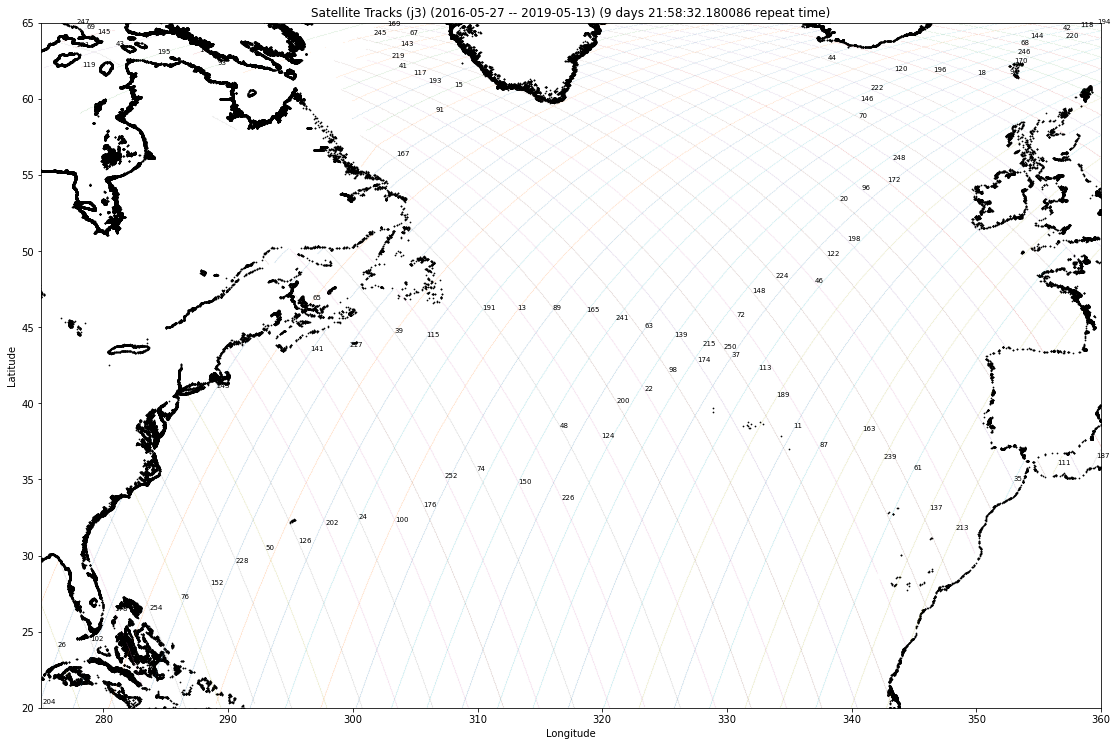

In [10]:
# figure of all tracks and their number (for refence when selecting single track)
f, ax = plt.subplots(1, 1, figsize = (19, 15))
ax.scatter(x4['lon'].values, x4['lat'].values, s=0.5, color='k')
for i in range(len(lon_record)):
    ax.scatter(lon_record[i], lat_record[i], s=0.001)
    ax.text(np.nanmedian(lon_record[i]), np.nanmedian(lat_record[i]), str(np.int(track_record[i])), fontsize=7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Satellite Tracks (' + this_sat + ')' + \
             ' (' + str(df2_s.index[0])[0:10] + ' -- ' + str(df2_s.index[-1])[0:10] + ') (' + str(repeat_time) + ' repeat time)')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
# ax.set_xlim([282, 287])
# ax.set_ylim([33, 37])
w = 1 / np.cos(np.deg2rad(35))
ax.set_aspect(w)
plt.show()
# f.savefig(this_sat + '_track_key', dpi=150)

In [4]:
# -- hor_grid_spacingby time 
# if desired subset tracks by desired time window to speed up computation time 
subset = 1
if subset:
    sub_time_ind = range(0, 15)  # (j3=38) (s3a = 20)
    adt_t_win = []
    sla_t_win = []
    time_t_win = []
    for i in tqdm(range(len(track_record))):
        adt_t_win.append(adt[i][sub_time_ind, :])
        sla_t_win.append(sla_int[i][sub_time_ind, :])
        time_t_win.append(time_record[i][sub_time_ind])
else:
    adt_t_win = adt
    sla_t_win = sla_int
    time_t_win = time_record

In [5]:
# redefine sla such that it is an anomaly relative 
# adt = sla + mdt 
# if we redefine sla such that it = adt - mean(adt) where mean(adt) is a time mean of a desired length (1yr vs. 20yrs.)
sla_star = []
for i in tqdm(range(len(adt))):
    sla_star.append(adt_t_win[i] - np.nanmean(adt_t_win[i], axis=0)) 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [18]:
# -- SMOOTH (the one/main iteration if not smoothing at multiple scales)
sla_smooth, adt_smooth = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, \
                                       coarsening_factor0, f_type, nyquist_wavelength)
# -- COARSEN 
dist_coarse, lon_coarse, lat_coarse, sla_coarse = coarsen(dist, lon_record, lat_record, coarsening_factor0, sla_smooth)
dist_coarse, lon_coarse, lat_coarse, adt_coarse = coarsen(dist, lon_record, lat_record, coarsening_factor0, adt_smooth)

Filter Half-Width = 
6 [0.12327988 0.11895676 0.1065763  0.08779966]
7 [0.12326621 0.11894309 0.10656263 0.08778599]
converged //
------------------------------------------------------------
for a coarsening factor of 5, recommend:
-- filter width of 15 grid cells (here = 150.0 km)
------------------------------------------------------------


track 53, too short
track 91, too short
track 117, too short
track 118, too short
track 134, too short
track 150, too short
track 166, too short
track 198, too short



/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:395: RuntimeWarning: Mean of empty slice
  (this_dist < coarse_grid[j])], axis=1)
/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:396: RuntimeWarning: Mean of empty slice
  coarse_lon[j - 1] = np.nanmean(this_lon[(this_dist > coarse_grid[j - 1]) & (this_dist < coarse_grid[j])])
/home/jovyan/along-track-altimetry-analysis/altimetry_tools.py:397: RuntimeWarning: Mean of empty slice
  coarse_lat[j - 1] = np.nanmean(this_lat[(this_dist > coarse_grid[j - 1]) & (this_dist < coarse_grid[j])])


In [15]:
# define coarsening factors to be equispaced in wavenumber space 
dx = hor_grid_spacing
L = 275                 # = number of grid points contributing to each spectral estimate
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))
inn = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
k_sub = k[inn]
coarsening_factors = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone = np.int(np.floor( (1/k_sub[i])/hor_grid_spacing ))
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    # exec(f'coarse_fac_{i} = {thisone}')
    coarsening_factors[i] = thisone
print(coarsening_factors)

smoothing to 270 km
smoothing to 225 km
smoothing to 190 km
smoothing to 170 km
smoothing to 150 km
smoothing to 135 km
smoothing to 120 km
smoothing to 110 km
smoothing to 100 km
smoothing to 95 km
smoothing to 90 km
smoothing to 85 km
smoothing to 80 km
smoothing to 75 km
smoothing to 70 km
smoothing to 65 km
[54. 45. 38. 34. 30. 27. 24. 22. 20. 19. 18. 17. 16. 15. 14. 13.]


In [16]:
# test smooth
%time sla_smooth_4, adt_smooth_4 = smooth_tracks(dist, adt_t_win, sla_star, lon_record, lat_record, \
                                                time_t_win, track_record, coarsening_factors[4], f_type, nyquist_wavelength)

Filter Half-Width = 
40 [0.02052482 0.02050458 0.02044393 0.02034312]
41 [0.02051373 0.02049348 0.02043284 0.02033203]
converged //
------------------------------------------------------------
for a coarsening factor of 30.0, recommend:
-- filter width of 83 grid cells (here = 415.0 km)
------------------------------------------------------------



CPU times: user 8min 23s, sys: 20.7 s, total: 8min 43s
Wall time: 8min 13s


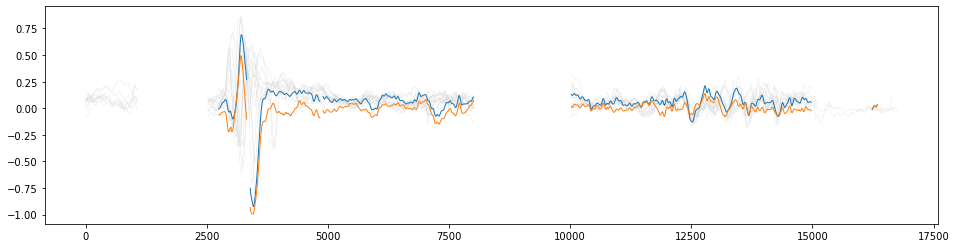

In [7]:
# check sla was gridded properly
t_i = np.array([24])  # s3a 33? # en 3 # J2 24,33,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 3
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]
xmax = 4000

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(sla_t_win[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], sla_t_win[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], sla_t_win[good_indi_dist][i, :], linewidth=1, label=r'SLA$_{interp}$')
    ax.plot(dist[good_indi_dist], sla_star[good_indi_dist][i, :], linewidth=1, label=r'SLA$_{newref}$')
    # ax.plot(dist[good_indi_dist], sla_smooth_4[good_indi_dist][i, :], linewidth=1, color='r', label=r'SLA$_{' + str(coarsening_factor0*hor_grid_spacing) + 'km}$')
plt.show()

In [ ]:
# -- SMOOTH & COARSEN (loop over desired coarsening factors)
sla_smooth_dic = []
adt_smooth_dic = []
for i in range(len(coarsening_factors)):
    sla_smooth_i, adt_smooth_i = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, \
                                               time_t_win, track_record, coarsening_factors[i], f_type, nyquist_wavelength)
    # dist_coarse_30, lon_coarse_30, lat_coarse_30, sla_coarse_30 = coarsen(dist, lon_record, lat_record, \
                                                # coarse_fac_0, sla_smooth_30)
    sla_smooth_dic.append(sla_smooth_i)
    adt_smooth_dic.append(adt_smooth_i)

In [43]:
# -- SMOOTH & COARSEN again 
sla_smooth_1, adt_smooth_1 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_1, f_type, nyquist_wavelength)
# dist_coarse_70, lon_coarse_70, lat_coarse_70, sla_coarse_70 = coarsen(dist, lon_record, lat_record, coarse_fac_1, sla_smooth_70)

# -- SMOOTH & COARSEN again 
sla_smooth_2, adt_smooth_2 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_2, f_type, nyquist_wavelength)
# dist_coarse_90, lon_coarse_90, lat_coarse_90, sla_coarse_90 = coarsen(dist, lon_record, lat_record, coarse_fac_2, sla_smooth_90)

# -- SMOOTH & COARSEN again 
sla_smooth_3, adt_smooth_3 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_3, f_type, nyquist_wavelength)
# dist_coarse_110, lon_coarse_110, lat_coarse_110, sla_coarse_110 = coarsen(dist, lon_record, lat_record, coarse_fac_3, sla_smooth_110)

# -- SMOOTH & COARSEN again 
sla_smooth_4, adt_smooth_4 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_4, f_type, nyquist_wavelength)
# dist_coarse_130, lon_coarse_130, lat_coarse_130, sla_coarse_130 = coarsen(dist, lon_record, lat_record, coarse_fac_4, sla_smooth_130)

# -- SMOOTH & COARSEN again 
sla_smooth_5, adt_smooth_5 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_5, f_type, nyquist_wavelength)
# dist_coarse_150, lon_coarse_150, lat_coarse_150, sla_coarse_150 = coarsen(dist, lon_record, lat_record, coarse_fac_5, sla_smooth_150)

# -- SMOOTH & COARSEN again 
sla_smooth_6, adt_smooth_6 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_6, f_type, nyquist_wavelength)
# dist_coarse_200, lon_coarse_200, lat_coarse_200, sla_coarse_200 = coarsen(dist, lon_record, lat_record, coarse_fac_6, sla_smooth_200)

# -- SMOOTH & COARSEN again 
sla_smooth_7, adt_smooth_7 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_7, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_8, adt_smooth_8 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_8, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_9, adt_smooth_9 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_9, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_10, adt_smooth_10 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_10, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_11, adt_smooth_11 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_11, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_12, adt_smooth_12 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_12, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_13, adt_smooth_13 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_13, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_14, adt_smooth_14 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_14, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

# -- SMOOTH & COARSEN again 
sla_smooth_15, adt_smooth_15 = smooth_tracks(dist, adt_t_win, sla_t_win, lon_record, lat_record, time_t_win, track_record, coarse_fac_15, f_type, nyquist_wavelength)
# dist_coarse_250, lon_coarse_250, lat_coarse_250, sla_coarse_250 = coarsen(dist, lon_record, lat_record, coarse_fac_7, sla_smooth_250)

save_p = 1
if save_p > 0:
    outputs = {'dist': dist, 'sla': sla_t_win, 
               'sla_smooth_0': sla_smooth_0, \
               'sla_smooth_1': sla_smooth_1, \
               'sla_smooth_2': sla_smooth_2, \
               'sla_smooth_3': sla_smooth_3, \
               'sla_smooth_4': sla_smooth_4, \
               'sla_smooth_5': sla_smooth_5, \
               'sla_smooth_6': sla_smooth_6, \
               'sla_smooth_7': sla_smooth_7, \
               'sla_smooth_8': sla_smooth_8, \
               'sla_smooth_9': sla_smooth_9, \
               'sla_smooth_10': sla_smooth_10, \
               'sla_smooth_11': sla_smooth_11, \
               'sla_smooth_12': sla_smooth_12, \
               'sla_smooth_13': sla_smooth_13, \
               'sla_smooth_14': sla_smooth_14, \
               'sla_smooth_15': sla_smooth_15, \
               'lon_record': lon_record, 'lat_record': lat_record, \
               'track': track_record, 'coarsening_factor_k': k_sub, 'grid_spacing': hor_grid_spacing, 'time': time_t_win}
    pickle.dump(outputs, open(this_sat + '_sharp_processed_by_k.p', 'wb'))

Filter Half-Width = 
71 [0.01141259 0.01140912 0.01139871 0.01138137]
72 [0.01140519 0.01140171 0.0113913  0.01137397]
converged //
------------------------------------------------------------
for a coarsening factor of 54, recommend:
-- filter width of 145 grid cells (here = 725.0 km)
------------------------------------------------------------



CPU times: user 12min 57s, sys: 34.5 s, total: 13min 32s
Wall time: 12min 30s
Filter Half-Width = 
60 [0.01368544 0.01367945 0.01366146 0.01363152]
61 [0.01367868 0.01367268 0.0136547  0.01362476]
converged //
------------------------------------------------------------
for a coarsening factor of 45, recommend:
-- filter width of 123 grid cells (here = 615.0 km)
------------------------------------------------------------



Filter Half-Width = 
51 [0.01620192 0.01619196 0.0161621  0.01611242]
52 [0.01619541 0.01618545 0.01615559 0.01610591]
converged //
------------------------------------------------------------
for a coarsening factor of 38, recommend:
-- filter width of 105 grid cells (here = 525.0 km)
------------------------------------------------------------



Filter Half-Width = 
46 [0.01810371 0.0180898  0.01804813 0.01797881]
47 [0.01809941 0.01808551 0.01804383 0.01797451]
converged //
------------------------------------------------------------
for a coarsening factor of 34, recommend:
-- filter width of 95 grid cells (here = 475.0 km)
------------------------------------------------------------



Filter Half-Width = 
40 [0.02052482 0.02050458 0.02044393 0.02034312]
41 [0.02051373 0.02049348 0.02043284 0.02033203]
converged //
------------------------------------------------------------
for a coarsening factor of 30, recommend:
-- filter width of 83 grid cells (here = 415.0 km)
------------------------------------------------------------



Filter Half-Width = 
36 [0.02280418 0.02277641 0.02269326 0.0225551 ]
37 [0.02279213 0.02276437 0.02268121 0.02254306]
converged //
------------------------------------------------------------
for a coarsening factor of 27, recommend:
-- filter width of 75 grid cells (here = 375.0 km)
------------------------------------------------------------



Filter Half-Width = 
32 [0.02565309 0.02561357 0.02549523 0.02529879]
33 [0.02564042 0.0256009  0.02548256 0.02528612]
converged //
------------------------------------------------------------
for a coarsening factor of 24, recommend:
-- filter width of 67 grid cells (here = 335.0 km)
------------------------------------------------------------



Filter Half-Width = 
30 [0.02797215 0.02792084 0.02776727 0.02751256]
31 [0.02797818 0.02792687 0.02777331 0.02751859]
converged //
------------------------------------------------------------
for a coarsening factor of 22, recommend:
-- filter width of 63 grid cells (here = 315.0 km)
------------------------------------------------------------



Filter Half-Width = 
27 [0.03077216 0.03070387 0.03049961 0.03016114]
28 [0.03077294 0.03070465 0.03050039 0.03016192]
converged //
------------------------------------------------------------
for a coarsening factor of 20, recommend:
-- filter width of 57 grid cells (here = 285.0 km)
------------------------------------------------------------



Filter Half-Width = 
26 [0.03238729 0.03230765 0.0320695  0.03167513]
27 [0.03240447 0.03232483 0.03208668 0.0316923 ]
converged //
------------------------------------------------------------
for a coarsening factor of 19, recommend:
-- filter width of 55 grid cells (here = 275.0 km)
------------------------------------------------------------



Filter Half-Width = 
24 [0.03419814 0.03410449 0.03382453 0.03336126]
25 [0.03418888 0.03409523 0.03381527 0.03335199]
converged //
------------------------------------------------------------
for a coarsening factor of 18, recommend:
-- filter width of 51 grid cells (here = 255.0 km)
------------------------------------------------------------



Filter Half-Width = 
23 [0.03619922 0.03608806 0.03575591 0.03520675]
24 [0.03621184 0.03610068 0.03576853 0.03521937]
converged //
------------------------------------------------------------
for a coarsening factor of 17, recommend:
-- filter width of 49 grid cells (here = 245.0 km)
------------------------------------------------------------



Filter Half-Width = 
44 [0.04137267 0.04123936 0.04084121 0.04018363]
45 [0.04139239 0.04125907 0.04086093 0.04020334]
converged //
------------------------------------------------------------
for a coarsening factor of 16, recommend:
-- filter width of 91 grid cells (here = 455.0 km)
------------------------------------------------------------



Filter Half-Width = 
20 [0.04103259 0.04087082 0.040388   0.03959155]
21 [0.04103383 0.04087206 0.04038923 0.03959278]
converged //
------------------------------------------------------------
for a coarsening factor of 15, recommend:
-- filter width of 43 grid cells (here = 215.0 km)
------------------------------------------------------------



Filter Half-Width = 
38 [0.04726786 0.04706893 0.04647565 0.04549847]
39 [0.04729884 0.04709991 0.04650662 0.04552945]
converged //
------------------------------------------------------------
for a coarsening factor of 14, recommend:
-- filter width of 79 grid cells (here = 395.0 km)
------------------------------------------------------------



Filter Half-Width = 
17 [0.04736471 0.04711631 0.04637619 0.04515947]
18 [0.0473389  0.0470905  0.04635038 0.04513366]
converged //
------------------------------------------------------------
for a coarsening factor of 13, recommend:
-- filter width of 37 grid cells (here = 185.0 km)
------------------------------------------------------------


In [19]:
# cross track velocity (from sla or adt)  # run for 'raw' or smoothed    
def velocity(dist, sla, lon_record, lat_record, track_record):   
    vel = []
    grad = []
    count = 0
    for m in tqdm(range(len(track_record))):
        # -- load in data for this track 
        this_sla = sla[m]  # interpolated field   
        lon_grid = lon_record[m]
        lat_grid = lat_record[m]
        d_grid = dist[m]
        these_cycles = np.arange(0, np.shape(this_sla)[0])
                  
        if len(d_grid) < 10:
            print('track ' + str(m) + ', too short') 
            grad.append(np.nan * np.ones(np.shape(this_sla)))
            vel.append(np.nan * np.ones(np.shape(this_sla)))
            continue
    
        grid_space = d_grid[1] - d_grid[0]
            
        # -- gradient (of interpolated field)
        # (pol_rad = 6378.137km) (eq_rad = 6356.752km) 
        f_loc = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat_grid))    
        
        # estimate gradient from Arbic 2012 
        sla_grad = np.gradient(this_sla, d_grid*1000.0, axis=1)
        for cdm in range(4, 4 + len(sla_grad[0, 4:-3])):
            # -- gradients from a 7 point stencil 
            sla_grad[:, cdm] = (this_sla[:, cdm+3] - 9*this_sla[:, cdm+2] + 45*this_sla[:, cdm+1] \
                                - 45*this_sla[:, cdm-1] + 9*this_sla[:, cdm-2] - this_sla[:, cdm-3]) / (60*(grid_space*1000.0))   
            
            # -- gradients from a 5 point stencil 
            # sla_grad[:, cdm] = (-this_adt[:, cdm+2] + 8*this_adt[:, cdm+1] - 8*this_adt[:, cdm-1] + this_adt[:, cdm-2]) / (12*(hor_grid_spacing*1000.0))

        # compute velocity via geostrophic balance 
        this_vel = (9.81/np.tile(f_loc[None, :], (len(these_cycles), 1))) * sla_grad  # np.gradient(this_interp_sla, d_grid*1000.0, axis=1)
        
        # near equator attempt beta plane correction from Lagerloef 1999 
        close_eq1 = np.where(np.abs(lat_grid) < 2.5)[0]
        if len(close_eq1) > 4:  # if there are points close to equator, make sure there are enough to compute a gradient
            beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_grid[close_eq1]))/(6356752)
            y = 1852 * 60 * (lat_grid[close_eq1] - 0)  # 6356752*lat_grid[close_eq1]  
            # weights transitioning from beta plane to f plane 
            wb = np.exp(-(np.abs(lat_grid[close_eq1])/2.2)**2)
            wf = 1 - wb           
            L = 111000
            theta = y/L
            
            # uf = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_grad[:, close_eq1]
            ub = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(sla_grad[:, close_eq1], y, axis=1)
            # uf_smooth = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_smooth_grad[:, close_eq1]
            # ub_smooth = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(adt_smooth_grad[:, close_eq1], y, axis=1)
            
            uf = (9.81/(np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]   # np.tile(1/theta[None, :], (len(these_cycles), 1))
            # ub1 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*y)) * adt_grad[:, close_eq1] # * np.tile(theta[None, :], (len(these_cycles), 1))
            # ub2 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**2, (len(these_cycles), 1))
            # ub3 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**3, (len(these_cycles), 1))
            # ub = ub1  # ub1 + ub2 + ub3
            ug = np.tile(wb[None, :], (len(these_cycles), 1))*ub + np.tile(wf[None, :], (len(these_cycles), 1))*uf
            this_vel[:, close_eq1] = ug 
        
        # -- save for each track arrays of fields [cycle X Distance] (each array is an element in a list)
        grad.append(sla_grad)
        vel.append(this_vel)
               
    return grad, vel

In [20]:
# VELOCITY (for a single smoothing choice)
# run for each variable 
sla_grad, adt_vel_t_win = velocity(dist, adt_t_win, lon_record, lat_record, track_record)
# sla_smooth_grad, sla_smooth_vel = velocity(dist, sla_smooth, lon_record, lat_record, track_record)
# sla_coarse_grad, sla_coarse_vel = velocity(dist_coarse, sla_coarse, lon_coarse, lat_coarse, track_record)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


track 53, too short
track 91, too short
track 117, too short
track 118, too short
track 134, too short
track 150, too short
track 166, too short
track 198, too short



In [21]:
# -- SMOOTH & COARSEN velocity (rather than compute velocity from smoothed sla)
coarsening_factor2 = coarsening_factor0
vel_smooth_50, adt_smooth_50 = smooth_tracks(dist, adt_t_win, adt_vel_t_win, lon_record, lat_record, time_t_win, track_record, \
                                       coarsening_factor2, f_type, nyquist_wavelength)
dist_coarse_50, lon_coarse_50, lat_coarse_50, vel_coarse_50 = coarsen(dist, lon_record, lat_record, coarsening_factor2, vel_smooth_50)

Filter Half-Width = 
6 [0.12327988 0.11895676 0.1065763  0.08779966]
7 [0.12326621 0.11894309 0.10656263 0.08778599]
converged //
------------------------------------------------------------
for a coarsening factor of 5, recommend:
-- filter width of 15 grid cells (here = 150.0 km)
------------------------------------------------------------


track 53, too short
track 91, too short
track 117, too short
track 118, too short
track 134, too short
track 150, too short
track 166, too short
track 198, too short



In [13]:
# -- SMOOTH & COARSEN velocity (rather than compute velocity from smoothed sla) -- GAUSSIAN REFERENCE
vel_smooth_g_50, adt_smooth_g_50 = smooth_tracks(dist, adt_t_win, adt_vel_t_win, lon_record, lat_record, time_t_win, track_record, \
                                       coarsening_factor2, 'gaussian', nyquist_wavelength)
dist_coarse_50, lon_coarse_50, lat_coarse_50, vel_coarse_g_50 = coarsen(dist, lon_record, lat_record, coarsening_factor2, vel_smooth_g_50)

track 53, too short
track 91, too short
track 117, too short
track 118, too short
track 134, too short
track 150, too short
track 166, too short
track 198, too short



/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


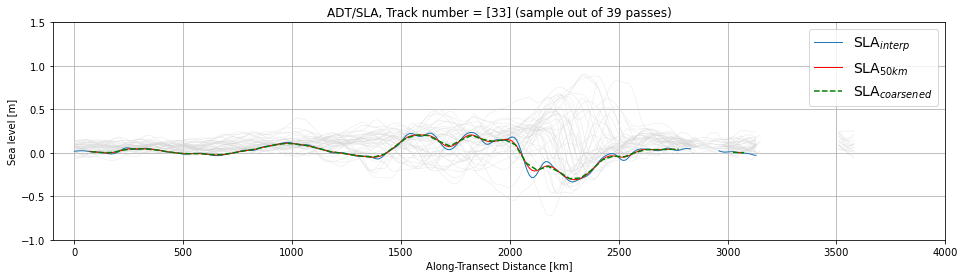

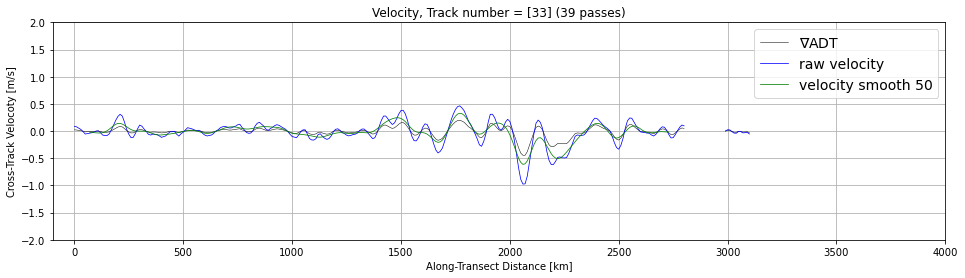

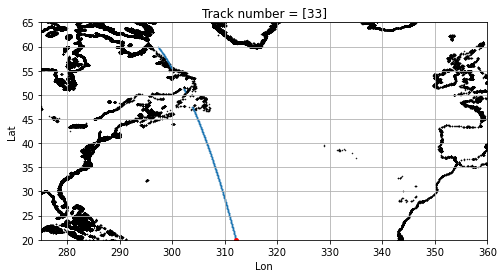

In [22]:
# -- choose a track (to show SLA, Vel, Track Location)
t_i = np.array([33])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 10
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]

xmax = 4000

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(sla[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], sla_int[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
    
eq_region = np.where(np.abs(lat_record[good_indi_dist]) < 0.1)[0]
if len(eq_region) > 0:
    ax.plot([dist[good_indi_dist][eq_region], dist[good_indi_dist][eq_region]], [-2, 2], color='k', linestyle='--')
    ax.text(dist[good_indi_dist][eq_region][0] + 30, -0.5, 'Equator')
    
for i in range(pass_index, pass_index + 1):
    # ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=1, color='k', label='SLA')
    ax.plot(dist[good_indi_dist], sla_int[good_indi_dist][i, :], linewidth=1, label=r'SLA$_{interp}$')
    ax.plot(dist[good_indi_dist], sla_smooth[good_indi_dist][i, :], linewidth=1, color='r', label=r'SLA$_{' + str(coarsening_factor0*hor_grid_spacing) + 'km}$')
    ax.plot(dist_coarse[good_indi_dist], sla_coarse[good_indi_dist][pass_index, :], label=r'SLA$_{coarsened}$', linestyle='--', color='g')
    # ax.plot(dist[good_indi_dist], adt[good_indi_dist][i, :], linewidth=1, color='b', label='ADT=MDT+SLA')
    # ax.plot(dist[good_indi_dist], adt_smooth[good_indi_dist][i, :], linewidth=1, color='b', linestyle='--')
ax.set_xlim([-100, xmax])
ax.set_ylim([-1, 1.5])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Sea level [m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_title('ADT/SLA, Track number = ' + str(t_i) + ' (sample out of ' + str(np.shape(sla[good_indi_dist])[0]) + ' passes)')
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_track', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (16, 4))
# for i in range(np.shape(sla[good_indi_dist])[0]):
#     ax.plot(dist[good_indi_dist], sla_vel[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], 50000*sla_grad[good_indi_dist][i, :], linewidth=0.5, color='k', label=r'$\nabla$ADT')
    ax.plot(dist[good_indi_dist], adt_vel_t_win[good_indi_dist][i, :], linewidth=0.75, color='b', label='raw velocity')
    ax.plot(dist[good_indi_dist], vel_smooth_50[good_indi_dist][i, :], linewidth=0.75, color='g', label='velocity smooth 50')
    # ax.plot(dist[good_indi_dist], sla_smooth_vel[good_indi_dist][i, :], linewidth=0.75, color='r', label='smooth velocity')
    # ax.plot(dist_coarse[good_indi_dist], sla_coarse_vel[good_indi_dist][i, :], linewidth=1.25, color='g', label='coarse velocity', linestyle='--')
ax.set_xlim([-100, xmax])
ax.set_ylim([-2, 2])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Cross-Track Velocoty [m/s]')
ax.set_title('Velocity, Track number = ' + str(t_i) + ' (' + str(np.shape(sla[good_indi_dist])[0]) + ' passes)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_velocity_track', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=0.25)
ax.scatter(lon_record[good_indi_dist][0], lat_record[good_indi_dist][0], s=15, color='r')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Track number = ' + str(t_i))
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_single_track', dpi=300)

In [9]:
# -- SPECTRAL PARAMETERS
# -- mesoscale wavenumber band
# meso = [70, 250]
# # -- half width of window over which to compute spectra 
# spec_win = 400  # should be at least as long meso[1], probably twice as large 
# # -- number of samples in each spectral estimate 
# spec_win_ind = np.int(spec_win / hor_grid_spacing) 
# dx = hor_grid_spacing
# L = np.int(spec_win_ind * 2) + 1 # = number of grid points contributing to each spectral estimate

# # -- for proper estimate of variance (integrating under the spectra) add factor of 2pi later 
# # k = np.arange(0, L/2, 1)/L/dx*2*np.pi
# # meso_ind = np.where((1/(k/2/np.pi) >= meso[0]) & (1/(k/2/np.pi) <= meso[-1]))[0]
# k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))  # *2*np.pi;
# meso_ind = np.where((1/(k) >= meso[0]) & (1/(k) <= meso[-1]))[0]

# # raw_spectra
# single = 0      # single track or not 
# taper = 0       # do we apply taper at edges of spectra
# taper_len = 0   # if taper, length of taper in grid cells 
# %time meso_slope_out, meso_spectra_out = spectra_slopes(track_record, dist, sla_int, k, L, dx, \
#                                                         meso, spec_win, spec_win_ind, taper, taper_len, single)

In [10]:
# -- loop over multiple smoothings
# sla_smooth_cf = []
# adt_smooth_cf = []
# cf = [2, 4, 6, 8, 10]  # factor to multiply byt grid spacing (now 20km) to set smoothing scale
# for i in range(len(cf)):
#     coarsening_factor = cf[i]  # this factor multiplies hor_grid_spacing
#     sigma = coarsening_factor/2  # half width of smoothing filter
#     sla_smooth_i, adt_smooth_i, tot_grad_i, vel_i, vel_tot_i, vel_tot_smooth_i = smooth_tracks(adt, sla_int, lon_record, lat_record, time_record, track_record, sigma)
#     sla_smooth_cf.append(sla_smooth_i)
#     adt_smooth_cf.append(adt_smooth_i)

# -- run to compare multiple smoothings 
# c_cf = ['b', 'c', 'g', 'y', 'r']
# f, ax = plt.subplots(1, 1, figsize = (5, 5))
# non_eq = np.where(np.abs(lat_record[good_indi_dist]) > 5)[0]
# for cc in range(len(cf)-1, -1, -1):
#     this_sla_s_c = sla_smooth_cf[cc]
#     for i in range(np.shape(this_sla_s_c[good_indi_dist])[0]):
#         ax.scatter(sla[good_indi_dist][i, non_eq]**2, (sla[good_indi_dist][i, non_eq] - this_sla_s_c[good_indi_dist][i, non_eq])**2, color=c_cf[cc], s=0.25)
#     ax.scatter(sla[good_indi_dist][i, non_eq]**2, (sla[good_indi_dist][i, non_eq] - this_sla_s_c[good_indi_dist][i, non_eq])**2, color=c_cf[cc], \
#                s=3, label=str(cf[cc]*hor_grid_spacing) + ' km')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, fontsize=11)
# # ax.set_ylim([0, 0.25])
# ax.set_xlim([0, 0.75])
# ax.set_yscale('log')
# ax.set_ylim([10**(-4), 10**0])
# ax.grid()
# plt.show()

# -- run only to compare multiple smoothings 
# f, ax = plt.subplots(1, 1, figsize = (5, 5))
# non_eq = np.where(np.abs(lat_record[good_indi_dist]) > 5)[0]
# for i in range(np.shape(vel_tot2[good_indi_dist])[0]):
#     ax.scatter(vel_tot2[good_indi_dist][i, non_eq], (vel_tot2[good_indi_dist][i, non_eq] - vel_tot_smooth2[good_indi_dist][i, non_eq]), color='r', s=0.25)
# ax.scatter(vel_tot2[good_indi_dist][i, non_eq], (vel_tot2[good_indi_dist][i, non_eq] - vel_tot_smooth2[good_indi_dist][i, non_eq]), color='r', s=3, label='100 km')

# for i in range(np.shape(vel_tot[good_indi_dist])[0]):
#     ax.scatter(vel_tot[good_indi_dist][i, non_eq], (vel_tot[good_indi_dist][i, non_eq] - vel_tot_smooth[good_indi_dist][i, non_eq]), color='g', s=0.5)
# ax.scatter(vel_tot[good_indi_dist][i, non_eq], (vel_tot[good_indi_dist][i, non_eq] - vel_tot_smooth[good_indi_dist][i, non_eq]), color='g', s=3, label='50km')

# for i in range(np.shape(vel_tot3[good_indi_dist])[0]):
#     ax.scatter(vel_tot3[good_indi_dist][i, non_eq], (vel_tot3[good_indi_dist][i, non_eq] - vel_tot_smooth3[good_indi_dist][i, non_eq]), color='b', s=0.25)
# ax.scatter(vel_tot3[good_indi_dist][i, non_eq], (vel_tot3[good_indi_dist][i, non_eq] - vel_tot_smooth3[good_indi_dist][i, non_eq]), color='b', s=3, label='20 km')

# ax.set_xlabel(r'$v$ [m/s]')
# ax.set_ylabel(r'$(v-v_{smooth})$')
# # ax.set_yscale('log')
# # ax.set_ylim([10**(-4), 10**1])
# ax.set_xlim([-3, 3])
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, fontsize=11)
# ax.set_title('Raw/Smoothed Velocity Difference (EKE)')
# ax.grid()
# plt.show()
# # f.savefig(this_sat + '_vel_error', dpi=300)

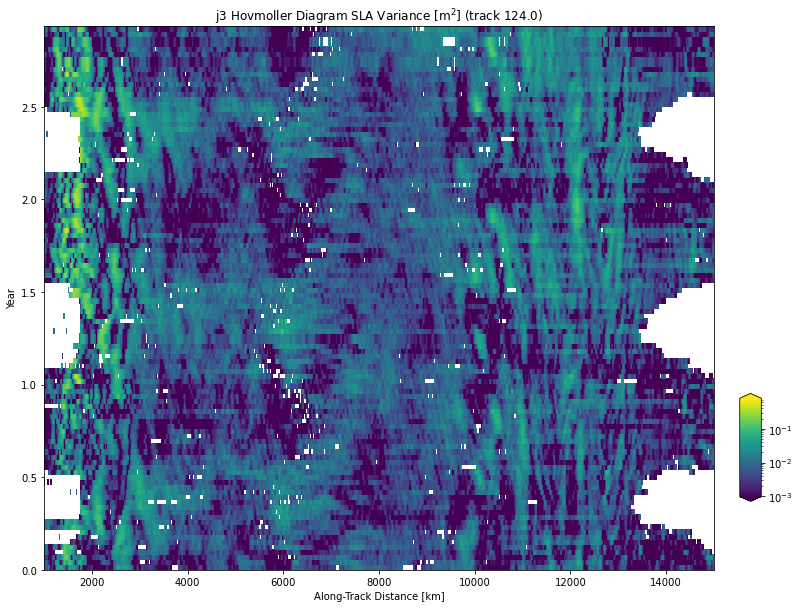

In [29]:
levs = np.arange(0.001, .8, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 10))
axp = ax.pcolor(dist[good_indi_dist], ((time_record[good_indi_dist] - time_record[good_indi_dist][0])/(60*60*24))/365, sla[good_indi_dist]**2, \
          norm=LogNorm(vmin=levs[0], vmax=levs[-1])) #  vmin=-.75, vmax=.75)
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA Variance [m$^2$] (track ' + str(track_record[good_indi_dist]) + ')')
ax.set_xlim([1000, 15000])
cbpos = [0.93, 0.22, 0.025, 0.15]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
plt.show()
f.savefig(this_sat + '_hovmoller', dpi=300)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


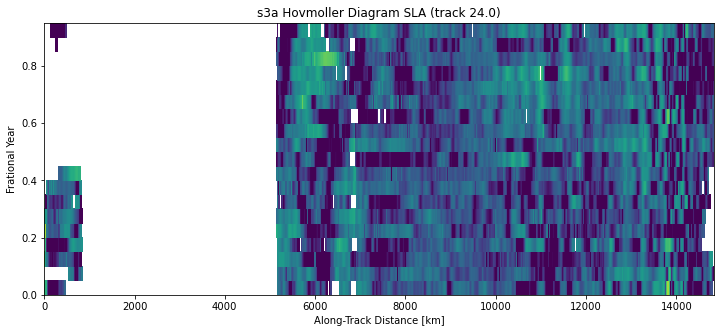

In [12]:
levs = np.arange(0.001, 0.5, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 5))
year_time_tot = ((time_record[good_indi_dist] - time_record[good_indi_dist][0])/(60*60*24))/365
year_time = np.mod(year_time_tot, 1)
t_step = np.arange(0, 1, 0.05)
sla_annual = np.nan * np.ones((len(t_step), np.shape(sla[good_indi_dist])[1]))
for i in range(len(t_step)-1):
    ii0 = t_step[i]
    ii1 = t_step[i+1]
    time_in = np.where((year_time > ii0) * (year_time < ii1))[0]
    sla_annual[i, :] = np.nanmean(sla[good_indi_dist][time_in, :], axis=0)
ax.pcolor(dist[good_indi_dist], t_step, sla_annual**2, norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Frational Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA (track ' + str(track_record[good_indi_dist]) + ')')
plt.show()
# f.savefig(this_sat + '_hovmoller_2_annual', dpi=300)

In [12]:
# ---------------   
# -- export to nc (for spectral analysis)
# ---------------
# variables = dist, sla, dist_coarse, sla_coarse, track_record 
# ---------------
save_p = 1
if save_p > 0:
    outputs = {'dist': dist, 'sla': sla_t_win, 
               'sla_smooth_0': sla_smooth_0, \
               'sla_smooth_1': sla_smooth_1, \
               'sla_smooth_2': sla_smooth_2, \
               'sla_smooth_3': sla_smooth_3, \
               'sla_smooth_4': sla_smooth_4, \
               'sla_smooth_5': sla_smooth_5, \
               'sla_smooth_6': sla_smooth_6, \
               'sla_smooth_7': sla_smooth_7, \
               'sla_smooth_8': sla_smooth_8, \
               'sla_smooth_9': sla_smooth_9, \
               'lon_record': lon_record, 'lat_record': lat_record, \
               'track': track_record, 'coarsening_factor_k': k_sub, 'grid_spacing': hor_grid_spacing, 'time': time_t_win}
#     outputs = {'dist': dist, 'sla': sla_int, 'vel_adt': adt_vel_t_win, 'sla_smooth': sla_smooth, 'sla_smooth_100': sla_smooth_100, \
#                'vel_smooth_100': vel_smooth_100, 'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'sla_coarse': sla_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'dist_coarse_100': dist_coarse_100, 'sla_coarse_100': sla_coarse_100, 'vel_coarse_100': vel_smooth_100, \
#                'lon_coarse_100': lon_coarse_100, 'lat_coarse': lat_coarse_100, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_record}
#     outputs = {'dist': dist, 'sla': sla_t_win, 'sla_smooth': sla_smooth, 'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'sla_coarse': sla_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_t_win}
    pickle.dump(outputs, open(this_sat + '_sharp_processed_by_k.p', 'wb'))

In [86]:
# bin variances 

step = 1
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 20
mean_sla = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c))) 
mean_v = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))               # velocity from adt
mean_v_anom = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # velocity anomaly (temporal)
mean_v_diff = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # EKE_1 (u - u_bar)**2
mean_v_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # EKE_2 (u**2 - u_bar**2)
mean_v_diff3 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # cross term (u_bar*u_prime) where u_prime = EKE_1
mean_v_diff3_gaussian = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
out_c = 0
for i in tqdm(range(len(lon_bins) - 1)):
    for j in range(len(lat_bins) - 1):
        this_lon0 = lon_bins[i]
        this_lon1 = lon_bins[i+1]
        this_lat0 = lat_bins[j]
        this_lat1 = lat_bins[j+1]
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1))[0]
            # repeat for coarse grid 
            inn2_coarse = np.where((lon_coarse[ai[tib]] > this_lon0) & (lon_coarse[ai[tib]] < this_lon1) & (lat_coarse[ai[tib]] > this_lat0) & (lat_coarse[ai[tib]] < this_lat1))[0]
            
            if count < 1:
                sla_i = sla[ai[tib]][:, inn2].flatten()
                adt_i = adt[ai[tib]][:, inn2].flatten()
                sla_smooth_i = sla_smooth[ai[tib]][:, inn2].flatten()
                adt_smooth_i = adt_smooth[ai[tib]][:, inn2].flatten()
                adt_coarse_i = adt_coarse[ai[tib]][:, inn2_coarse].flatten()         # adt coarse
                vel_i = adt_vel_t_win[ai[tib]][:, inn2].flatten()                    # velocity from raw sla
                vel_i_anom = (adt_vel_t_win[ai[tib]][:, inn2] - np.nanmean(adt_vel_t_win[ai[tib]][:, inn2], axis=0)).flatten() # velocity from raw sla
                vel_smooth_i = vel_smooth_50[ai[tib]][:, inn2].flatten()             # velocity from smoothed raw velocity
                # vel_smooth_g_i = vel_smooth_g_50[ai[tib]][:, inn2].flatten()
                
                count = count + 1
            else:
                sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
                adt_i = np.append(adt_i, adt[ai[tib]][:, inn2].flatten())
                sla_smooth_i = np.append(sla_smooth_i, sla_smooth[ai[tib]][:, inn2].flatten())
                adt_smooth_i = np.append(adt_smooth_i, adt_smooth[ai[tib]][:, inn2].flatten())
                adt_coarse_i = np.append(adt_coarse_i, adt_coarse[ai[tib]][:, inn2_coarse].flatten())
                vel_i = np.append(vel_i, adt_vel_t_win[ai[tib]][:, inn2].flatten())
                vel_i_anom = np.append(vel_i_anom, (adt_vel_t_win[ai[tib]][:, inn2] - np.nanmean(adt_vel_t_win[ai[tib]][:, inn2], axis=0)).flatten()) 
                vel_smooth_i = np.append(vel_smooth_i, vel_smooth_50[ai[tib]][:, inn2].flatten())
                # vel_smooth_g_i = np.append(vel_smooth_g_i, vel_smooth_g_50[ai[tib]][:, inn2].flatten())

        # save vel info 
        if out_c < 1:
            cross_out = (vel_smooth_i*(vel_smooth_i - vel_i))
            bar_out = vel_smooth_i
            tot_out = vel_i
            out_c = 1
        else:
            cross_out = np.append(cross_out, (vel_smooth_i*(vel_smooth_i - vel_i)))
            bar_out = np.append(bar_out, vel_smooth_i)
            tot_out = np.append(tot_out, vel_i)

        if (len(ai) > 1):
            if (len(sla_i) > thresh):
                mean_sla[i, j] = np.nanmean(sla_i**2)           # like a raw eddy energy estimate 
                mean_adt[i, j] = np.nanmean(adt_i)              # raw adt
                mean_sla_smooth[i, j] = np.nanmean(sla_smooth_i**2)     # smooth sla
                mean_adt_smooth[i, j] = np.nanmean(adt_coarse_i)     # smooth adt
                mean_adt_coarse[i, j] = np.nanmean(adt_coarse_i)     # coarse adt
                # mean_diff1[i, j] = (np.nanmean(adt_i) - np.nanmean(adt_coarse_i))**2   # adt - smooth_adt (like an eddy energy estimate)  (np.nanmean((adt_i - adt_s_i)**2))
                # mean_diff1[i, j] = np.nanmean((sla_i**2 - sla_smooth_i**2))/np.nanmean(sla_i**2)   # adt - smooth_adt (like an eddy energy estimate)  
                # mean_diff2[i, j] = np.nanmean(np.abs((adt_i - adt_s_i)/adt_i))
                
                mean_v[i, j] = np.nanmean(vel_i**2)                                        # calculated from adt gradients 
                mean_v_anom[i, j] = np.nanmean(vel_i_anom**2)                              # temporal EKE def 
                mean_v_diff[i, j] = np.nanmean((vel_i - vel_smooth_i)**2)                  # calculated from coarse sla 
                mean_v_diff2[i, j] = np.nanmean((vel_i**2 - vel_smooth_i**2))              # calculated from coarse sla 
                mean_v_diff3[i, j] = np.nanmean((vel_smooth_i*(vel_smooth_i - vel_i)))     # u_bar*u_prime 
                # mean_v_diff3_gaussian[i, j] = np.nanmean((vel_smooth_g_i*(vel_smooth_g_i - vel_i)))  # u_bar*u_prime 
                # mean_slope[i, j] = np.nanmean(sloper)
                # mean_slope_smooth[i, j] = np.nanmean(sloper1)
        ai = 0

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of

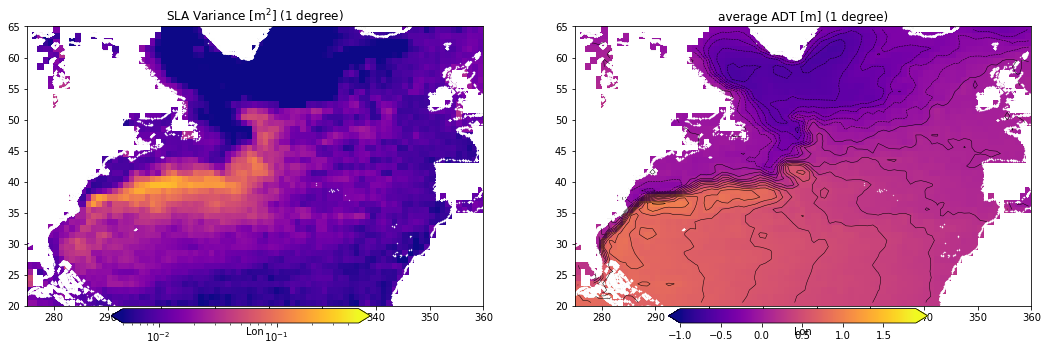

In [26]:
# SLA / ADT 
cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
levs = np.arange(0.005, 0.5, 0.01)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
ax1.set_xlabel('Lon')
ax1.set_title(r'SLA Variance [m$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

adt_lev = np.arange(-1, 2, 0.1)
ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_adt), vmin=adt_lev[0], vmax=adt_lev[-1], zorder=0, cmap=plt.get_cmap('plasma'))
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
ax2.set_xlabel('Lon')
ax2.set_title(r'average ADT [m] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
# f.savefig(this_sat + '_adt_map.jpg', dpi=400)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


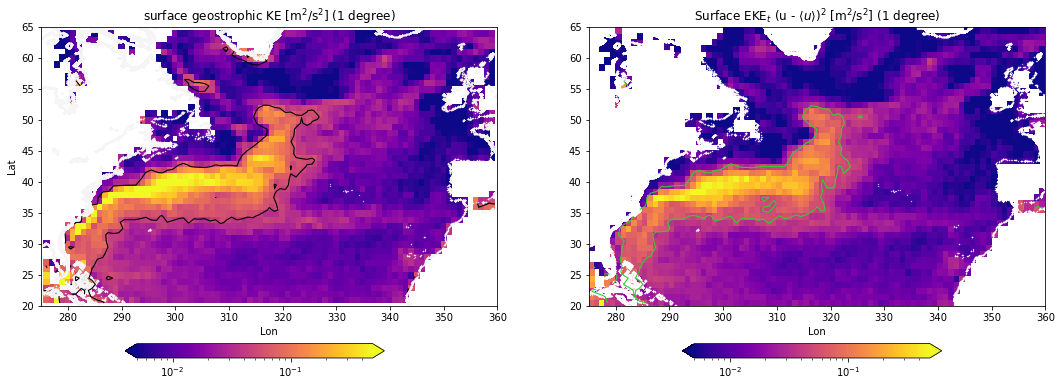

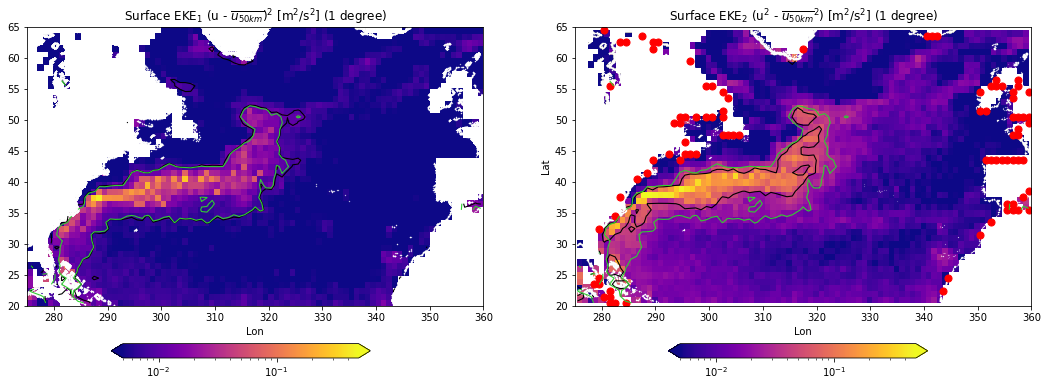

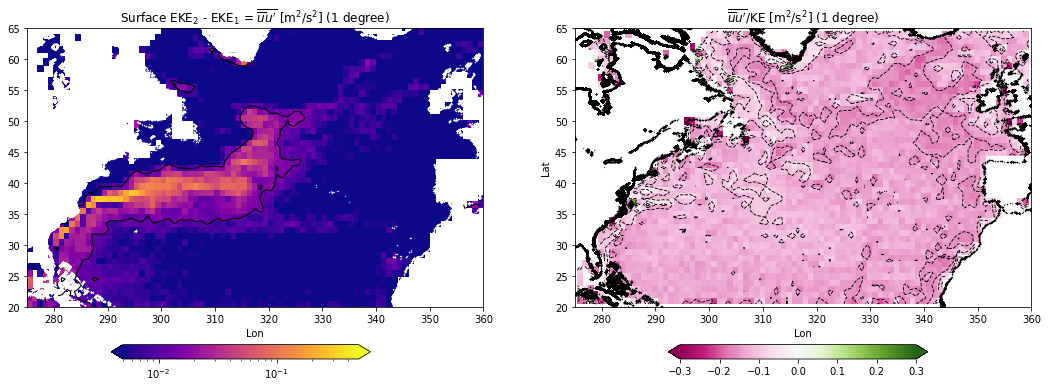

In [96]:
# sla velocity and adt velocity 
# plot, excluding equator 
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
# total KE 
mean_v_mask = mean_v.copy()
mean_v_mask[:, v_in] = np.nan
# EKE time
mean_v_mask_time = mean_v_anom.copy()
mean_v_mask_time[:, v_in] = np.nan
# EKE 1
mean_v_tot_mask = mean_v_diff.copy()
mean_v_tot_mask[:, v_in] = np.nan
# EKE 2
mean_v_tot_mask2 = mean_v_diff2.copy()
mean_v_tot_mask2[:, v_in] = np.nan
mean_v_tot_mask2_negative_eke = np.transpose(mean_v_tot_mask2.copy())
Lon_c, Lat_c = np.meshgrid(lon_bin_c, lat_bin_c)
Lon_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lat_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lon_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
Lat_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
# EKE cross term
mean_v_tot_mask3 = mean_v_diff3.copy()
mean_v_tot_mask3[:, v_in] = np.nan
# mean_v_tot_mask3_g = mean_v_diff3_gaussian.copy()
# mean_v_tot_mask3_g[:, v_in] = np.nan

save_f = 1 

# --------------- fig 1
cbpos = [[0.19, 0.17, 0.2, 0.025], [0.62, 0.17, 0.2, 0.025]]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
levs = np.arange(0.005, 0.5, 0.01)
levs2 = [0.35]  
levs3 = [0.05]
levs4 = [0.025]
ax1.scatter(x4['lon'].values, x4['lat'].values, color='whitesmoke', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap='plasma')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=1.1, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'surface geostrophic KE [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v_mask_time), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_title(r'Surface EKE$_{t}$ (u - $\left< u \right>$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_1.jpg', dpi=300)

# --------- fig 2 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
# EKE 1 
ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v_tot_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax1.set_xlabel('Lon')
ax1.set_title(r'Surface EKE$_1$ (u - $\overline{u_{50km}}$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# EKE 2 
ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
ax2.scatter(Lon_c.flatten(), Lat_c.flatten(), s=50, color='r')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r'Surface EKE$_2$ (u$^2$ - $\overline{u_{50km}}^2$) [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_2.jpg', dpi=300)


# --------- fig 3
# levs2 = np.arange(0.035, 0.036, 0.01)
levs_cross = np.arange(0.005, 0.5, 0.01)
levs_frac = np.arange(-0.3, 0.35, 0.05)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# EKE 2 - EKE 1 (should equal the cross term)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp2 = ax1.pcolor(lon_bins, lat_bins, np.transpose(np.abs(mean_v_tot_mask2 - mean_v_tot_mask)), norm=LogNorm(vmin=levs_cross[0], vmax=levs_cross[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(np.abs((mean_v_tot_mask2 - mean_v_tot_mask)/mean_v_tot_mask3)), vmin=1.75, vmax=2.25, zorder=0, cmap=plt.get_cmap('PiYG'))
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
ax1.set_xlabel('Lon')
ax1.set_title(r"Surface EKE$_2$ - EKE$_1$ = $\overline{\overline{u}u'}$ [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp2, cax=cax, orientation='horizontal', extend='both')

# cross term as a fraction
ax2.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), vmin=levs_frac[0], vmax=levs_frac[-1], zorder=0, cmap=plt.get_cmap('PiYG'))
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), levels=levs_frac, zorder=1, linewidths=0.9, colors='k')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r"$\overline{\overline{u}u'}$/KE [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_3.jpg', dpi=300)

# ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(np.abs(mean_v_tot_mask3_g)), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(np.abs(mean_v_tot_mask3_g)), levels=levs2, zorder=1, linewidths=0.9, colors='c')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(np.abs(mean_v_tot_mask3)), levels=levs2, zorder=1, linewidths=0.9, colors='w')
# ax2.set_xlabel('Lon')
# ax2.set_title(r'Cross Term (gaussian) $\overline{u_{50km}}*$(u - $\overline{u_{50km}}$) [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax2.set_xlim([lon_w, lon_e])
# ax2.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# plt.show()
# if save_f:
#     f.savefig(this_sat + '_vel_eke_3.jpg', dpi=300)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


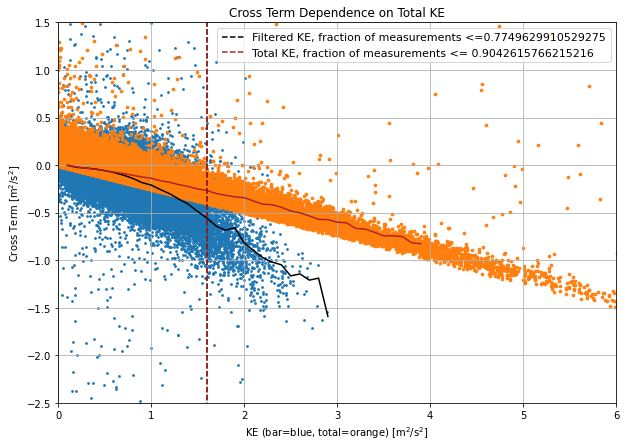

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [143]:
ke_bar = bar_out**2
ke_tot = tot_out**2
f, ax = plt.subplots(1, 1, figsize=(10,7))
ax.scatter(ke_bar, cross_out, s=3)
ax.scatter(ke_tot, cross_out, s=7)
ke_bin = np.arange(0, 4, 0.1)
ke_bin_c = ke_bin[0:-1] + np.diff(ke_bin)
ke_bar_mean = np.nan * np.ones(len(ke_bin_c))
ke_tot_mean = np.nan * np.ones(len(ke_bin_c))
bar_count = np.nan * np.ones((1, len(ke_bin_c)))
tot_count = np.nan * np.ones((1, len(ke_bin_c)))
for i in tqdm(range(len(ke_bin) - 1)):
    ke_bar_mean[i] = np.nanmean(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    ke_tot_mean[i] = np.nanmean(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
    bar_count[0, i] = len(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    tot_count[0, i] = len(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
ax.plot(ke_bin_c, ke_bar_mean, color='k', linewidth=1.5)
ax.plot(ke_bin_c, ke_tot_mean, color='firebrick', linewidth=1.5)
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='k', linestyle='--', label='Filtered KE, fraction of measurements <=' + str(np.nansum(bar_count[0, 0:15])/len(ke_bar)))
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='firebrick', linestyle='--', label='Total KE, fraction of measurements <= ' + str(np.nansum(tot_count[0, 0:15])/len(ke_tot)))
ax.set_xlabel(r'KE (bar=blue, total=orange) [m$^2$/s$^2$]')
ax.set_ylabel('Cross Term [m$^2$/s$^2$]')
ax.set_title('Cross Term Dependence on Total KE')
ax.set_xlim([0, 6])
ax.set_ylim([-2.5, 1.5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.grid()
plt.show()
f.savefig(this_sat + '_cross_terms.jpg', dpi=300)

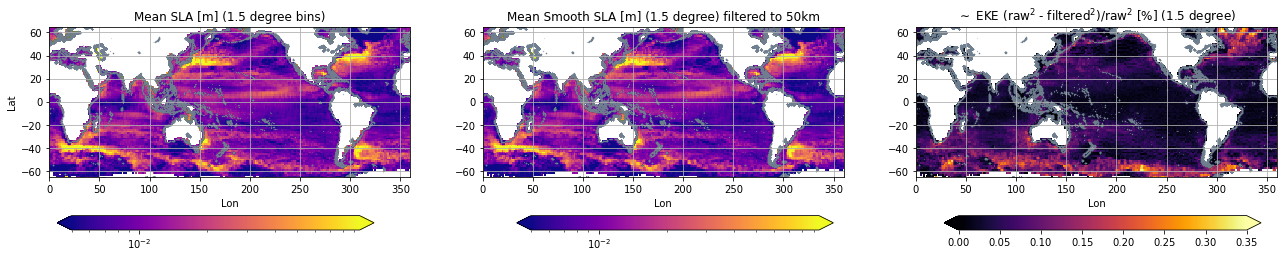

In [34]:
cbpos = [[0.13, 0.28, 0.2, 0.025], [0.42, 0.28, 0.2, 0.025], [0.69, 0.28, 0.2, 0.025]]
# cbpos = [[0.93, 0.68, 0.025, 0.2], [0.93, 0.4, 0.025, 0.2], [0.93, 0.15, 0.025, 0.2]]
# cbpos = [[0.19, 0.2, 0.2, 0.025], [0.62, 0.2, 0.2, 0.025]]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize = (22, 8))

# levs = np.arange(0.00001, 0.2, 0.01)
# lev = np.arange(0, 1, 0.1)
levs = np.arange(0.005, 0.1, 0.01)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))  # norm=LogNorm(vmin=levs[0], vmax=levs[-1])
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'Mean SLA [m] (' + str(step) + ' degree bins)')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax2.set_xlabel('Lon')
ax2.set_title(r'Mean Smooth SLA [m] (' + str(step) + ' degree) filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

# levs = np.arange(0.0000001, 0.001, 0.0001)
# levs = np.arange(0.001, 1, 0.001)
ax3.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1), vmin=-0, vmax=.35, zorder=0, cmap=plt.get_cmap('inferno'))  # np.abs((adt_i - adt_s_i)/adt_i)
ax3.set_xlabel('Lon')
ax3.set_title(r'$\sim$ EKE (raw$^2$ - filtered$^2$)/raw$^2$ [%] (' + str(step) + ' degree)')
# ax3.set_title(r'$\sim$ EKE |(raw - smoothed)/raw| [fraction] (' + str(step) + ' degree)')
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

f.savefig(this_sat + '_sla_map_50km_diff.jpg', dpi=400)

In [ ]:
# print(datetime.utcfromtimestamp(time_record[20][0]))
# print(datetime.utcfromtimestamp(time_record[20][-1]))
# print(time_record[20][-1]/(60*60*24) - time_record[20][0]/(60*60*24))
# total_days = time_record[20][-1]/(60*60*24) - time_record[20][0]/(60*60*24)
# time_bins = np.arange(time_record[20][0], time_record[20][-1], 31)
# print(datetime.utcfromtimestamp(time_bins[0]))

In [ ]:
# -- testing of sharp filter 
# def specsharp(grid_spacing, coarse_fac, nyquist_wavenumber):     
#     # -- get filter weights for a given filter width, n grid cells
#     def getWeights(n):  
#         w = np.zeros(n+1) # initialize weights
#         for i in range(n):
#             integrand = lambda k: 2*(F(k)-1)*(np.cos((i+1)*k)-1)
#             w[i] = integrate.quad(integrand,0,np.pi)[0]
#         A = 2*np.pi*(np.eye(n) + 2)
#         w[1:] = np.linalg.solve(A,w[0:n])
#         w[0] = 1 - 2*np.sum(w[1:])
#         return w
    
#     x = coarse_fac                  # coarsening factor (actual 'width' is a function of grid spacing)
#     # nyquist_wavenumber = smallest resolvable scale on the 'new' grid 
#     F = interpolate.PchipInterpolator(np.array([0, 1/x, nyquist_wavenumber/x, nyquist_wavenumber]), np.array([1, 1, 0, 0]))
#     print('Filter Half-Width = ')    
            
#     weight_prev = getWeights(2)
#     # loop over filter widths until weights converge
#     for j in range(3, 40):  # 40 might not be enough? 
#         this_weight = getWeights(j)
#         # difference between these weights and last iterations (looking for convergence)
#         wd = np.sum(np.abs(this_weight[0:3] - weight_prev[0:3]) / np.abs(weight_prev[0:3]))  
#         if wd < 0.001:  # convergence threshold 
#             jj = j
#             print(str(j - 1) + ' ' + str(getWeights(j - 1)[0:4]))
#             print(str(j) + ' ' + str(getWeights(j)[0:4]))
#             print('converged //')
#             break
#         weight_prev = this_weight   
            
#     filter_kernel = np.concatenate((np.flip(getWeights(jj))[0:-1], getWeights(jj)))
#     print('------------------------------------------------------------')
#     print('for a coarsening factor of ' + str(coarse_fac) + ', recommend:')
#     print('-- filter width of ' + str(2*jj + 1) + ' grid cells (here = ' + str(grid_spacing * (2*jj + 1)) + ' km)')
#     print('------------------------------------------------------------')
#     return filter_kernel, jj

In [ ]:
# import netCDF4
# file_out = '/home/jovyan/along-track-altimetry-analysis/' + fig_names + '.nc' 
# save_nc = 1
# if save_nc > 0:
#     OL_out = netCDF4.Dataset(file_out, 'w', format='NETCDF4_CLASSIC')
#     # create dimenision
#     # list_dim = OL_out.createDimension('list_dim', len(lon_t))  # list of all values
#     track_dim = OL_out.createDimension('track_dim', len(np.array([track_record])))
#     # -- assign variables
# #     lon_out = OL_out.createVariable('lon_list', np.float64, ('list_dim'))
# #     lon_out[:] = lon_t
# #     lat_out = OL_out.createVariable('lat_list', np.float64, ('list_dim'))
# #     lat_out[:] = lat_t
# #     sla_out = OL_out.createVariable('sla_list', np.float64, ('sla_dim'))
# #     sla_out[:] = sla_t
# #     track_out = OL_out.createVariable('track_list', np.float64, ('track_dim'))
# #     track_out[:] = lon_check
#     # -- by track variables 
#     lon_bt_out = OL_out.createVariable('lon_bt', np.float64, ('track_dim'))
#     lon_bt_out[:] = np.array([lon_record])
#     lat_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     lat_bt_out[:] = np.array([lat_record])
#     dist_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     dist_bt_out[:] = np.array([dist]) 
#     sla_bt_out = OL_out.createVariable('lon_bt', np.float64, ('track_dim'))
#     sla_bt_out[:] = np.array([sla])
#     track_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     track_bt_out[:] = np.array([track_record])  
#     OL_out.close() 

In [ ]:
# ---------------   
# -- export to nc (for testing with mspec)
# ---------------
# import netCDF4
# save_nc = 1
# if save_nc > 0:
#     OL_out = netCDF4.Dataset('test_out.nc', 'w', format='NETCDF4_CLASSIC')
#     # create dimenision
#     dist_dim = OL_out.createDimension('dist_dim', len(this_x))
#     prof_num_dim = OL_out.createDimension('cycle_dim', np.shape(this_sla)[0])
#     # assign variables
#     dist_out = OL_out.createVariable('dist_grid', np.float64, ('dist_dim'))
#     dist_out[:] = this_x   
#     u_out = OL_out.createVariable('sla', np.float64, ('cycle_dim', 'dist_dim'))
#     u_out[:] = this_sla
#     v_out = OL_out.createVariable('sla_smooth', np.float64, ('cycle_dim', 'dist_dim'))
#     v_out[:] = this_sla_smooth
#     OL_out.close() 

In [ ]:
# f, ax = plt.subplots(1, 1, figsize = (13, 7))
# for i in range(len(this_track)):
#     ax.scatter(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0, dist_by_track[this_track[i]][:, 1], s=0.2, label=time_log[this_track[i]])
# ax.set_xlabel('Along-Track Distance [km] (track=' + str(track_i) + ')')
# ax.set_ylabel('SLA [m]')
# ax.set_title('Sea Level Anomaly (2017)')
# # handles, labels = ax.get_legend_handles_labels()
# # ax.legend(handles, labels, fontsize=7)
# ax.grid()
# plt.show()

In [ ]:
# lon_bins = np.arange(0, 361, 2)
# lat_bins = np.arange(-70, 71, 2)

# # helps with memory management
# ds_ll_chunked = ds_tot.chunk({'time': '5MB'})

# sla_variance = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude,
#                          bins=[lon_bins, lat_bins],
#                          weights=ds_ll_chunked.sla_filtered.fillna(0.)**2)

# norm = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude,
#                          bins=[lon_bins, lat_bins])


# # let's get at least 200 points in a box for it to be unmasked
# thresh = 100
# sla_variance = sla_variance / norm.where(norm > thresh)

In [ ]:
# cutoff = 50
# data = sla[102]
# grid = dist[102]
# num_tracks = np.shape(data)[0]
# # -- search for good data
# # look at each track at each depth and inventory the number of nans, but also the number of nan segments and the segment lengths 
# seg_out = {}
# seg_out_count = {}
# good_indices_0 = []
# good_indices = np.zeros(num_tracks)
# print('interpolating by track')
# for i in tqdm(range(num_tracks)):  # loop over tracks
#     this_track = data[i, :]  # CALL ACTUAL DATA HERE 
#     bad = np.where(np.isnan(this_track))[0]  # nan indices 
#     seg = []
#     if ((len(bad) >= 2) & (len(bad) < len(this_track))):
#         breaky = np.where(np.diff(bad) > 1)[0] + 1  # look for breaks in list of nans 
#         if len(breaky) > 0:      
#             seg.append([bad[0], bad[breaky[0] - 1]])
#             for b in range(len(breaky) - 1):
#                 seg.append([bad[breaky[b]], bad[breaky[b + 1] - 1]])
#             # last index 
#             if bad[breaky[-1]] == bad[-1]:
#                 seg.append([bad[breaky[-1]], bad[breaky[-1]]])    
#             else:
#                 seg.append([bad[breaky[-1]], bad[breaky[-1]]]) 
#         elif (len(breaky) == 0) & (bad[0] > 0): 
#             seg = [bad[0], bad[-1]]    
#         elif (len(breaky) == 0) & (bad[0] == 0):
#             seg = [bad[0], bad[-1]]   
    
#     elif len(bad) == 1:
#         seg = [bad[0], bad[0]]
#     elif len(bad) == len(this_track):
#         seg = len(data[0, :])  # all are nan's 
#     else:
#         seg = 0  # none are nans     
#     seg_out[i] = seg    
#     # this is a dictionary with coordinates (1, profile) identifying nan segments and their length 
                
#     # inspect seg_out to see which are good and which might meet some defined criteria 
#     if (seg != 0) & (seg != len(data[0, :])):
#         spacer = np.nan * np.ones(len(seg))
#         if len(np.shape(seg)) > 1:
#             for b2 in range(len(seg)):
#                 spacer[b2] = seg[b2][1] - seg[b2][0]
#             seg_out_count[i] = spacer  # np.nanmax(spacer)  
#         else:
#             seg_out_count[i] = seg[1] - seg[0]
#     elif seg == 0:
#         seg_out_count[i] = np.nan        
                      
# # interpolate
# interpolated_signal = data.copy()
# for i in tqdm(range(num_tracks)): # interpolate only transects that meet nan_seg criteria 
#     this_u = data[i, :]
#     interp_sig = interpolated_signal[i, :].copy()
#     these_segments = seg_out[i]
#     if these_segments == 0:
#         continue
#     if np.sum(np.isnan(this_u)) == len(this_u):
#         continue
#     else:
#         for j in range(len(these_segments)):
#             if len(np.isfinite(np.shape(seg_out_count[i]))) == 1:
#                 if these_segments[j][0] == (len(this_u) - 1):
#                     continue
#                 if seg_out_count[i][j] <= cutoff:
#                     this_seg_s = these_segments[j][0] - 1
#                     this_seg_e = these_segments[j][-1] + 1
#                     interp_sig[this_seg_s:this_seg_e+1] = np.interp(grid[this_seg_s:this_seg_e+1], [grid[this_seg_s], grid[this_seg_e]], [this_u[this_seg_s], this_u[this_seg_e]])
#             elif len(seg_out_count) == 1:
#                 interp_sig[these_segments[0]:these_segments[-1]+1] = nanseg_interp(grid[these_segments[0]:these_segments[-1]+1], [grid[these_segments[0]], grid[these_segments[-1]]], [this_u[these_segments[0]], this_u[these_segments[-1]]])
            
#     interpolated_signal[i, :] = interp_sig